In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Install required packages
!pip install open-clip-torch timm

In [45]:
# Import all necessary libraries
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import open_clip
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import logging

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4


In [46]:

def create_logger(log_dir: str, name: str = "A-CLIP", level: str = "INFO") -> logging.Logger:
    Path(log_dir).mkdir(parents=True, exist_ok=True)
    logger = logging.getLogger(name)
    logger.setLevel(getattr(logging, level.upper(), logging.INFO))
    logger.propagate = False  # avoid duplicate logs

    # Clear old handlers if cell re-run
    if logger.handlers:
        for h in list(logger.handlers):
            logger.removeHandler(h)

    # Console handler
    ch = logging.StreamHandler()
    ch.setLevel(logger.level)

    # Simple file handler (overwrite each run)
    fh = logging.FileHandler(os.path.join(log_dir, f"{name}.log"), mode="w")
    fh.setLevel(logger.level)

    fmt = logging.Formatter(
        fmt="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S"
    )
    ch.setFormatter(fmt)
    fh.setFormatter(fmt)

    logger.addHandler(ch)
    logger.addHandler(fh)
    return logger


device = 'cuda' if torch.cuda.is_available() else 'cpu'

LOG_DIR = "/kaggle/working/clip/logs"
logger = create_logger(LOG_DIR, name="A-CLIP", level="INFO")
logger.info("Logger initialized.")
logger.info(f"PyTorch: {torch.__version__}, CUDA available: {torch.cuda.is_available()}")
logger.info(f"Device in use: {device}")


2025-09-14 01:44:05 | INFO | A-CLIP | Logger initialized.
2025-09-14 01:44:05 | INFO | A-CLIP | PyTorch: 2.6.0+cu124, CUDA available: True
2025-09-14 01:44:05 | INFO | A-CLIP | Device in use: cuda


In [47]:
# Configuration parameters

class Config:
    # Paths
    DATA_DIR = Path("/kaggle/input")  # Adjust based on your dataset location
    RUNS_DIR = Path("/kaggle/working")
    
    # Model settings
    NUM_CLASSES = 15  # Adjust based on your dataset
    SEED = 42
    
    # CLIP Training hyperparameters
    # EPOCHS = 10
    # EFFECTIVE_BS_CLIP = 4096 # change to 2  # Effective batch size
    # MICRO_BS_CLIP = 64     # Micro batch size (fits in memory)
    # LR = 1e-4
    # WEIGHT_DECAY = 1e-4
    # WARMUP_EPOCHS = 2

    # A-CLIP trainning hyperparameters
    EPOCHS = 10
    EFFECTIVE_BS_ACLIP = 4096
    MICRO_BS_ACLIP = 64
    LR = 1e-4
    WEIGHT_DECAY = 1e-4
    
    # Fine-tuning settings
    FULL_FINETUNE = True     # Set to False for linear probe only
    PIN_MEMORY = False
    N_WORKERS = 0

    IMAGE_SIZE = 224
    
    # # Effective batch sizes per assignment
    # EFFECTIVE_BS_CLIP = 32
    # EFFECTIVE_BS_ACLIP = 32
    # EFFECTIVE_BS_SIGLIP = 32768
    SAVE_EVERY = 10
    # Per-device micro-batch sizes (adjust if you OOM; increase if you have big GPU)
    # MICRO_BS_CLIP = 64
    # MICRO_BS_ACLIP = 64
    # MICRO_BS_SIGLIP = 128  # SigLIP favors large batches; we simulate via accumulation
    
    WARMUP_EPOCHS = 1

    #==================
config = Config()

print("Configuration loaded successfully!")

Configuration loaded successfully!


In [48]:
def set_seed(seed):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
def ensure_dir(path):
    """Create directory if it doesn't exist"""
    path.mkdir(parents=True, exist_ok=True)
    
def count_params(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def compute_grad_accum(effective_bs, micro_bs):
    """Compute gradient accumulation steps"""
    return effective_bs // micro_bs

def cuda_memory_peak_mb():
    """Get peak GPU memory usage in MB"""
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / 1024 / 1024
    return 0.0

def reset_cuda_peak():
    """Reset peak memory tracking"""
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

def write_csv_header(csv_path, headers):
    """Write CSV header"""
    with open(csv_path, 'w') as f:
        f.write(','.join(headers) + '\n')

def log_row(csv_path, row):
    """Log a row to CSV"""
    with open(csv_path, 'a') as f:
        f.write(','.join(map(str, row)) + '\n')

def print_cuda_mem(tag=""):
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**2
        reserved  = torch.cuda.memory_reserved() / 1024**2
        print(f"[{tag}] CUDA allocated={allocated:.1f} MB | reserved={reserved:.1f} MB")


def get_logits_fn(model, head, images):
    # images: (B,3,224,224) normalized
    # 1) compute patch mask
    keep_mask = mask_low_saliency_tokens(images, patch_size=PATCH_SIZE, keep_ratio=KEEP_RATIO)  # (B,49)

    # 2) run CLIP encode_image but intercept final pooled feature by masking tokens:
    # open_clip's encode_image returns pooled features; to simulate masking, we use encode_visual features:
    # Unfortunately open_clip doesn't expose token embeddings directly; workaround:
    # We rely on encode_image output (global feature) and attenuate it by the fraction kept (proxy).
    # For a closer approximation, full hooks into ViT blocks would be needed.
    feats = model.encode_image(images)  # (B,dim)
    # Scale feature magnitude to reflect fraction of kept tokens (heuristic proxy)
    frac = keep_mask.float().mean(dim=1, keepdim=True)  # (B,1)
    feats = feats * frac  # downweight if many patches were dropped

    logits = head(feats)    
    return logits

def mask_low_saliency_tokens(images, patch_size=32, keep_ratio=0.5):
    """
    images: (B,3,H,W) -> returns a boolean mask per patch: (B, num_patches)
    keep_ratio: fraction of patches to keep (e.g., 0.5 keeps top 50% by saliency)
    """
    B, _, H, W = images.shape
    sal = _sobel_energy(images)  # (B,1,H,W)
    # average saliency inside non-overlapping patches
    sal_pool = F.avg_pool2d(sal, kernel_size=patch_size, stride=patch_size)  # (B,1,H/ps,W/ps)
    sal_flat = sal_pool.view(B, -1)  # (B, num_patches)
    k = (sal_flat.size(1) * keep_ratio)
    k = int(math.ceil(k))
    # keep top-k
    topk = torch.topk(sal_flat, k=k, dim=1).indices  # (B,k)
    mask = torch.zeros_like(sal_flat, dtype=torch.bool)
    mask.scatter_(1, topk, True)  # True for kept patches
    return mask  # (B, num_patches)

print("Utility functions loaded!")

def train_epoch(model_tuple, train_loader, optimizer, device, 
                contrastive_loss_fn, classification_loss_fn, 
                scaler, grad_accum_steps, get_logits_fn, 
                epoch, total_epochs, embed_dim=None):
    model, head = model_tuple
    model.train()
    head.train()
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    total_contrastive = 0.0
    total_classification = 0.0
    
    start_time = time.time()
    
    for batch_idx, (images, targets) in enumerate(train_loader):
        images, targets = images.to(device), targets.to(device)
        
        with torch.cuda.amp.autocast():
            logits = get_logits_fn((model, head), images)
            
            # Split loss into contrastive + classification parts
            classification_loss = classification_loss_fn(logits, targets)
            contrastive_loss = contrastive_loss_fn(logits, targets)  # placeholder (adjust as needed)
            
            loss = (classification_loss + contrastive_loss) / grad_accum_steps
        
        scaler.scale(loss).backward()
        
        if (batch_idx + 1) % grad_accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        total_loss += loss.item() * grad_accum_steps
        total_contrastive += contrastive_loss.item()
        total_classification += classification_loss.item()
        
        pred = logits.argmax(dim=1)
        total_correct += (pred == targets).sum().item()
        total_samples += targets.size(0)
    
    epoch_time = time.time() - start_time
    
    return {
        "total_loss": total_loss / len(train_loader),
        "accuracy": total_correct / total_samples,
        "contrastive_loss": total_contrastive / len(train_loader),
        "classification_loss": total_classification / len(train_loader),
        "epoch_time": epoch_time
    }


@torch.no_grad()
def evaluate(model_tuple, data_loader, device, 
             contrastive_loss_fn, classification_loss_fn, 
             get_logits_fn, embed_dim=None):
    model, head = model_tuple
    model.eval()
    head.eval()
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    total_contrastive = 0.0
    total_classification = 0.0
    
    start_time = time.time()
    
    for images, targets in data_loader:
        images, targets = images.to(device), targets.to(device)
        
        with torch.cuda.amp.autocast():
            logits = get_logits_fn((model, head), images)
            
            classification_loss = classification_loss_fn(logits, targets)
            contrastive_loss = contrastive_loss_fn(logits, targets)  # adjust if needed
            
            loss = classification_loss + contrastive_loss
        
        total_loss += loss.item()
        total_contrastive += contrastive_loss.item()
        total_classification += classification_loss.item()
        
        pred = logits.argmax(dim=1)
        total_correct += (pred == targets).sum().item()
        total_samples += targets.size(0)
    
    eval_time = time.time() - start_time
    
    return {
        "total_loss": total_loss / len(data_loader),
        "accuracy": total_correct / total_samples,
        "contrastive_loss": total_contrastive / len(data_loader),
        "classification_loss": total_classification / len(data_loader),
        "eval_time": eval_time
    }

print("Training functions defined!")

Utility functions loaded!
Training functions defined!


In [49]:
# mask_utils.py
import torch
import torch.nn.functional as F
import math

def _sobel_energy(x):
    # x: (B,3,H,W), normalized. Return per-pixel energy map (B,1,H,W)
    gx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=x.dtype, device=x.device).view(1,1,3,3)
    gy = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=x.dtype, device=x.device).view(1,1,3,3)
    gray = x.mean(1, keepdim=True)
    ex = F.conv2d(gray, gx, padding=1)
    ey = F.conv2d(gray, gy, padding=1)
    return (ex**2 + ey**2).sqrt()



In [22]:
!ls /kaggle/input


human-action-recognition-dataset


In [ ]:
# ===== Folder-based HAR loaders (Structured/train, Structured/test) =====
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets
import open_clip

DATA_ROOT = Path("/kaggle/input/human-action-recognition-dataset")  
STRUCTURED = DATA_ROOT / "Structured"  

def _ls(path, n=8):
    try:
        kids = [p.name for p in Path(path).iterdir()][:n]
        print(f"[ls] {path} -> {kids}")
    except Exception as e:
        print(f"[ls] {path} -> <error: {e}>")

def get_loaders(micro_bs: int, num_workers: int = 2):
    # CLIP transforms (train/val)
    print("called getloader  1")
    _, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
        'ViT-B-32', pretrained='openai'
    )

    train_dir = STRUCTURED / "train"
    test_dir  = STRUCTURED / "test"

    if not train_dir.exists() or not test_dir.exists():
        raise RuntimeError(
            "Expected folder layout not found.\n"
            f"train_dir: {train_dir} (exists={train_dir.exists()})\n"
            f"test_dir : {test_dir} (exists={test_dir.exists()})\n"
            "Make sure your dataset is mounted and the path in DATA_ROOT is correct."
        )

    # quick test print
    _ls(train_dir); _ls(test_dir)

    # ImageFolder will look for class subfolders
    train_ds = datasets.ImageFolder(str(train_dir), transform=preprocess_train)
    test_ds  = datasets.ImageFolder(str(test_dir),  transform=preprocess_val)

    if len(train_ds) == 0 or len(test_ds) == 0:
        raise RuntimeError(
            "Found 0 samples. Ensure images are inside class subfolders under train/ and test/."
        )

    classes = train_ds.classes
    print(f"Classes ({len(classes)}): {classes[:10]}{'...' if len(classes) > 10 else ''}")
    print(f"Train samples: {len(train_ds)} | Test samples: {len(test_ds)}")

    # train_loader = DataLoader(
    #     train_ds, batch_size=micro_bs, shuffle=True,
    #     num_workers=num_workers, pin_memory=True
    # )
    # test_loader = DataLoader(
    #     test_ds, batch_size=micro_bs, shuffle=False,
    #     num_workers=num_workers, pin_memory=True
    # )
    # train_loader = DataLoader(train_ds, batch_size=config.MICRO_BS_CLIP,
    #                       shuffle=True, num_workers=config.N_WORKERS,
    #                       pin_memory=config.PIN_MEMORY, persistent_workers=False)
    # test_loader  = DataLoader(test_ds, batch_size=config.MICRO_BS_CLIP,
    #                       shuffle=False, num_workers=config.N_WORKERS,
    #                       pin_memory=config.PIN_MEMORY, persistent_workers=False)
    # return train_loader, test_loader, classes

    train_loader = DataLoader(train_ds, batch_size=config.MICRO_BS_ACLIP,
                          shuffle=True,  num_workers=config.N_WORKERS,
                          pin_memory=config.PIN_MEMORY, persistent_workers=False)

    test_loader  = DataLoader(test_ds,  batch_size=config.MICRO_BS_ACLIP,
                          shuffle=False, num_workers=config.N_WORKERS,
                          pin_memory=config.PIN_MEMORY, persistent_workers=False)

    return train_loader, test_loader, classes

print(" Folder-based loaders (Structured/) ready.")


In [52]:
def build_model(device, num_classes, embed_dim= None, full_finetune=True):
    """
    Build CLIP backbone with a classification head.
    
    Args:
        device (torch.device): CPU/GPU device.
        num_classes (int): Number of output classes.
        embed_dim (int): Embedding dimension for the head (default 4096).
        full_finetune (bool): If True, finetune the entire backbone. 
                              If False, freeze backbone and train only head.
    """
    # Load CLIP backbone
    model, _, _ = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')

    # Use CLIP's output dimension unless overridden
    dim = embed_dim if embed_dim is not None else model.visual.output_dim

    # Classification head
    head = nn.Linear(dim, num_classes)

    if not full_finetune:
        # Linear probe → freeze backbone
        for p in model.parameters():
            p.requires_grad = False
        params = head.parameters()
    else:
        # Full finetune → train backbone + head
        print("full fine tune active")
        params = list(model.parameters()) + list(head.parameters())

    return model.to(device), head.to(device), params


In [53]:
# load A-CLIP MODEL
KEEP_RATIO = 0.5   # keep top 50% patches by saliency
PATCH_SIZE = 32    # ViT-B/32 patch size (for 224x224 => 7x7=49 tokens)


def main():
    set_seed(config.SEED)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    out_dir = config.RUNS_DIR / "aclip"  # Changed from "clip" to "aclip"
    ensure_dir(out_dir)
    csv_path = out_dir / "metrics.csv"
    
    write_csv_header(csv_path, [
        "epoch", "train_loss", "train_acc", "val_loss", "val_acc",
        "contrastive_loss", "classification_loss",  # A-CLIP specific losses
        "epoch_time_s", "peak_mem_mb", "trainable_params"
    ])
    
    print("Loading A-CLIP data...")
    # train_loader, test_loader, classes = get_aclip_loaders(config.MICRO_BS_ACLIP, num_workers=2)
    train_loader, test_loader, classes = get_loaders(config.MICRO_BS_ACLIP, num_workers=2)
    
    logger.info(f"Detected {len(classes)} classes: {classes}")
    logger.info(f"Train samples: {len(train_loader.dataset)} | Test samples: {len(test_loader.dataset)}")
    
    actual_num_classes = len(classes)
    print(f"Detected {actual_num_classes} classes: {classes}")
    
    print("Building A-CLIP model...")
    model, head, params = build_model(
    device, 
    actual_num_classes, 
    embed_dim=512, 
    full_finetune=config.FULL_FINETUNE)

    # model, head, params = build_model(device, actual_num_classes, embed_dim=4096)
    trainable_params = count_params(model) + count_params(head) if config.FULL_FINETUNE else count_params(head)
    logger.info(f"A-CLIP model built. Embed dim: 4096, Trainable params: {trainable_params/1e6:.2f}M")
    
    # A-CLIP specific optimizations
    try:
        model.set_grad_checkpointing(True)   # reduce memory with checkpointing
        if hasattr(model, 'enable_attention_checkpointing'):
            model.enable_attention_checkpointing(True)  # A-CLIP specific
    except Exception:
        pass

    try:
        model = model.to(memory_format=torch.channels_last)  # better memory layout
        if hasattr(model, 'audio_encoder'):
            model.audio_encoder = model.audio_encoder.to(memory_format=torch.channels_last)
    except Exception:
        pass
    
    # Setup optimizer and loss function for A-CLIP
    optimizer = optim.AdamW(params, lr=config.LR, weight_decay=config.WEIGHT_DECAY)
    
    # A-CLIP uses both contrastive and classification losses
    contrastive_loss_fn = nn.CrossEntropyLoss()  # For CLIP-style contrastive learning
    classification_loss_fn = nn.CrossEntropyLoss()  # For classification head
    
    # Mixed precision scaler
    scaler = torch.amp.GradScaler(device="cuda")
    grad_accum = compute_grad_accum(config.EFFECTIVE_BS_ACLIP, config.MICRO_BS_ACLIP)
    
    print(f"Classes: {classes}")
    print(f"A-CLIP Embed Dim: 4096")
    print(f"Effective BS: {config.EFFECTIVE_BS_ACLIP} (micro {config.MICRO_BS_ACLIP} x accum {grad_accum})")
    print(f"Trainable params: {trainable_params/1e6:.2f}M")
    
    # Training loop
    best_acc = 0.0
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    contrastive_losses, classification_losses = [], []
    
    for epoch in range(config.EPOCHS):
        reset_cuda_peak()
        
        # Train A-CLIP
        # train_metrics = train_epoch(
        #     model=(model, head),
        #     train_loader=train_loader,
        #     optimizer=optimizer,
        #     device=device,
        #     contrastive_loss_fn=contrastive_loss_fn,
        #     classification_loss_fn=classification_loss_fn,
        #     scaler=scaler,
        #     grad_accum_steps=grad_accum,
        #     get_logits_fn=lambda mh, data: get_aclip_logits_fn(mh[0], mh[1], data),
        #     epoch=epoch,
        #     total_epochs=config.EPOCHS,
        #     embed_dim=4096
        # )
        train_metrics = train_epoch(
            (model, head),
            train_loader,
            optimizer,
            device,
            contrastive_loss_fn,
            classification_loss_fn,
            scaler,
            grad_accum,
            lambda mh, data: get_logits_fn(mh[0], mh[1], data),
            epoch,
            config.EPOCHS,
            embed_dim=None
        )

        
        train_loss = train_metrics['total_loss']
        train_acc = train_metrics['accuracy']
        contrastive_loss = train_metrics['contrastive_loss']
        classification_loss = train_metrics['classification_loss']
        epoch_time = train_metrics['epoch_time']
        
        print_cuda_mem(f"after A-CLIP train E{epoch+1}")

        # Evaluate A-CLIP
        
        # val_metrics = evaluate(
        #     model=(model, head),
        #     test_loader=test_loader,
        #     device=device,
        #     contrastive_loss_fn=contrastive_loss_fn,
        #     classification_loss_fn=classification_loss_fn,
        #     get_logits_fn=lambda mh, data: get_aclip_logits_fn(mh[0], mh[1], data),
        #     embed_dim=4096
        # )

        val_metrics = evaluate(
            (model, head),
            test_loader,
            device,
            contrastive_loss_fn,
            classification_loss_fn,
            lambda mh, data: get_logits_fn(mh[0], mh[1], data),
            embed_dim=4096
        )

        val_loss = val_metrics['total_loss']
        val_acc = val_metrics['accuracy']
        
        print_cuda_mem(f"after A-CLIP val E{epoch+1}")
        torch.cuda.empty_cache()

        peak_mem = cuda_memory_peak_mb()
        
        # Log metrics with A-CLIP specific losses
        log_row(csv_path, [
            epoch+1, f"{train_loss:.4f}", f"{train_acc:.4f}",
            f"{val_loss:.4f}", f"{val_acc:.4f}",
            f"{contrastive_loss:.4f}", f"{classification_loss:.4f}",
            f"{epoch_time:.2f}", f"{peak_mem:.1f}", int(trainable_params)
        ])
        
        # Store for plotting
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        contrastive_losses.append(contrastive_loss)
        classification_losses.append(classification_loss)

        logger.info(f"[A-CLIP] E{epoch+1}/{config.EPOCHS} | "
            f"train {train_loss:.4f}/{train_acc:.3f} | "
            f"val {val_loss:.4f}/{val_acc:.3f} | "
            f"contr {contrastive_loss:.4f} | class {classification_loss:.4f} | "
            f"{epoch_time:.1f}s | peak {peak_mem:.1f}MB") 
            
        print(f"[A-CLIP] E{epoch+1}/{config.EPOCHS} | "
              f"train {train_loss:.4f}/{train_acc:.3f} | "
              f"val {val_loss:.4f}/{val_acc:.3f} | "
              f"contr {contrastive_loss:.4f} | class {classification_loss:.4f} | "
              f"{epoch_time:.1f}s | peak {peak_mem:.1f}MB")
        
        # Save best A-CLIP model
        if val_acc > best_acc:
            best_acc = val_acc
            checkpoint = {
                "model_state_dict": model.state_dict(),
                "head_state_dict": head.state_dict(),
                "classes": classes,
                "config": config.__dict__,
                "epoch": epoch + 1,
                "best_acc": best_acc,
                "embed_dim": 4096,
                "model_type": "aclip",
                "contrastive_losses": contrastive_losses,
                "classification_losses": classification_losses
            }
            torch.save(checkpoint, out_dir / "best_aclip_model.pt")
            logger.info(f"New best A-CLIP model saved with accuracy: {best_acc:.4f} at epoch {epoch+1}") 
            print(f"New best A-CLIP model saved with accuracy: {best_acc:.4f}")
            print_cuda_mem(f"after save E{epoch+1}")

        if (epoch + 1) % config.SAVE_EVERY == 0:
        
            intermediate_checkpoint = {
                "model_state_dict": model.state_dict(),
                "head_state_dict": head.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "classes": classes,
                "config": config.__dict__,
                "epoch": epoch + 1,
                "current_acc": val_acc,
                "embed_dim": 4096,
                "model_type": "aclip"
            }
            torch.save(intermediate_checkpoint, out_dir / f"aclip_checkpoint_epoch_{epoch+1}.pt")
            print(f"Intermediate A-CLIP checkpoint saved at epoch {epoch+1}")

        
    logger.info(f"A-CLIP training completed! Best validation accuracy: {best_acc:.4f}") 
    print(f"\nA-CLIP training completed! Best validation accuracy: {best_acc:.4f}")
    
    return {
        "model": model,
        "head": head,
        "classes": classes,
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "contrastive_losses": contrastive_losses,
        "classification_losses": classification_losses,
        "best_acc": best_acc,
        "embed_dim": 4096,
        "model_type": "aclip"
    }

# Run A-CLIP training
print("Starting A-CLIP training with 4096 embedding dimension...")
logger.info("Starting A-CLIP training with 4096 embedding dimension...")

results = main()

2025-09-14 01:46:47 | INFO | A-CLIP | Starting A-CLIP training with 4096 embedding dimension...


Starting A-CLIP training with 4096 embedding dimension...
Using device: cuda
Loading A-CLIP data...
called getloader  1
[ls] /kaggle/input/human-action-recognition-dataset/Structured/train -> ['sitting', 'listening_to_music', 'dancing', 'running', 'calling', 'drinking', 'hugging', 'laughing']
[ls] /kaggle/input/human-action-recognition-dataset/Structured/test -> ['sitting', 'listening_to_music', 'dancing', 'running', 'calling', 'drinking', 'hugging', 'laughing']


2025-09-14 01:46:56 | INFO | A-CLIP | Detected 15 classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
2025-09-14 01:46:56 | INFO | A-CLIP | Train samples: 10710 | Test samples: 1890


Classes (15): ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music']...
Train samples: 10710 | Test samples: 1890
Detected 15 classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Building A-CLIP model...


2025-09-14 01:46:57 | INFO | A-CLIP | A-CLIP model built. Embed dim: 4096, Trainable params: 151.29M


full fine tune active
Classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
A-CLIP Embed Dim: 4096
Effective BS: 4096 (micro 64 x accum 64)
Trainable params: 151.29M


/tmp/ipykernel_36/3249573674.py:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[after A-CLIP train E1] CUDA allocated=4486.7 MB | reserved=5368.0 MB


/tmp/ipykernel_36/3249573674.py:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
2025-09-14 01:48:15 | INFO | A-CLIP | [A-CLIP] E1/10 | train 5.3210/0.130 | val 5.0639/0.248 | contr 2.6605 | class 2.6605 | 69.0s | peak 4859.1MB


[after A-CLIP val E1] CUDA allocated=4486.7 MB | reserved=5368.0 MB
[A-CLIP] E1/10 | train 5.3210/0.130 | val 5.0639/0.248 | contr 2.6605 | class 2.6605 | 69.0s | peak 4859.1MB


2025-09-14 01:48:16 | INFO | A-CLIP | New best A-CLIP model saved with accuracy: 0.2476 at epoch 1


New best A-CLIP model saved with accuracy: 0.2476
[after save E1] CUDA allocated=4486.7 MB | reserved=4848.0 MB
[after A-CLIP train E2] CUDA allocated=3156.5 MB | reserved=5316.0 MB


2025-09-14 01:49:33 | INFO | A-CLIP | [A-CLIP] E2/10 | train 5.0777/0.251 | val 4.9794/0.285 | contr 2.5389 | class 2.5389 | 68.8s | peak 4859.6MB


[after A-CLIP val E2] CUDA allocated=3156.5 MB | reserved=5316.0 MB
[A-CLIP] E2/10 | train 5.0777/0.251 | val 4.9794/0.285 | contr 2.5389 | class 2.5389 | 68.8s | peak 4859.6MB


2025-09-14 01:49:35 | INFO | A-CLIP | New best A-CLIP model saved with accuracy: 0.2852 at epoch 2


New best A-CLIP model saved with accuracy: 0.2852
[after save E2] CUDA allocated=3156.5 MB | reserved=3744.0 MB
[after A-CLIP train E3] CUDA allocated=3156.5 MB | reserved=3902.0 MB


2025-09-14 01:50:51 | INFO | A-CLIP | [A-CLIP] E3/10 | train 4.7170/0.422 | val 4.3745/0.546 | contr 2.3585 | class 2.3585 | 68.1s | peak 3530.7MB


[after A-CLIP val E3] CUDA allocated=3156.5 MB | reserved=3902.0 MB
[A-CLIP] E3/10 | train 4.7170/0.422 | val 4.3745/0.546 | contr 2.3585 | class 2.3585 | 68.1s | peak 3530.7MB


2025-09-14 01:50:52 | INFO | A-CLIP | New best A-CLIP model saved with accuracy: 0.5455 at epoch 3


New best A-CLIP model saved with accuracy: 0.5455
[after save E3] CUDA allocated=3156.5 MB | reserved=3744.0 MB
[after A-CLIP train E4] CUDA allocated=3156.5 MB | reserved=3902.0 MB


2025-09-14 01:52:09 | INFO | A-CLIP | [A-CLIP] E4/10 | train 4.0481/0.599 | val 3.7261/0.602 | contr 2.0241 | class 2.0241 | 67.9s | peak 3530.7MB


[after A-CLIP val E4] CUDA allocated=3156.5 MB | reserved=3902.0 MB
[A-CLIP] E4/10 | train 4.0481/0.599 | val 3.7261/0.602 | contr 2.0241 | class 2.0241 | 67.9s | peak 3530.7MB


2025-09-14 01:52:10 | INFO | A-CLIP | New best A-CLIP model saved with accuracy: 0.6016 at epoch 4


New best A-CLIP model saved with accuracy: 0.6016
[after save E4] CUDA allocated=3156.5 MB | reserved=3744.0 MB
[after A-CLIP train E5] CUDA allocated=3156.5 MB | reserved=3902.0 MB


2025-09-14 01:53:28 | INFO | A-CLIP | [A-CLIP] E5/10 | train 3.5455/0.628 | val 3.4593/0.594 | contr 1.7728 | class 1.7728 | 69.0s | peak 3530.7MB


[after A-CLIP val E5] CUDA allocated=3156.5 MB | reserved=3902.0 MB
[A-CLIP] E5/10 | train 3.5455/0.628 | val 3.4593/0.594 | contr 1.7728 | class 1.7728 | 69.0s | peak 3530.7MB
[after A-CLIP train E6] CUDA allocated=3156.5 MB | reserved=3902.0 MB


2025-09-14 01:54:44 | INFO | A-CLIP | [A-CLIP] E6/10 | train 3.2329/0.652 | val 2.9953/0.680 | contr 1.6164 | class 1.6164 | 68.1s | peak 3530.7MB


[after A-CLIP val E6] CUDA allocated=3156.5 MB | reserved=3902.0 MB
[A-CLIP] E6/10 | train 3.2329/0.652 | val 2.9953/0.680 | contr 1.6164 | class 1.6164 | 68.1s | peak 3530.7MB


2025-09-14 01:54:46 | INFO | A-CLIP | New best A-CLIP model saved with accuracy: 0.6804 at epoch 6


New best A-CLIP model saved with accuracy: 0.6804
[after save E6] CUDA allocated=3156.5 MB | reserved=3744.0 MB
[after A-CLIP train E7] CUDA allocated=3156.5 MB | reserved=3902.0 MB


2025-09-14 01:56:02 | INFO | A-CLIP | [A-CLIP] E7/10 | train 2.6805/0.728 | val 2.5934/0.695 | contr 1.3402 | class 1.3402 | 67.9s | peak 3530.7MB


[after A-CLIP val E7] CUDA allocated=3156.5 MB | reserved=3902.0 MB
[A-CLIP] E7/10 | train 2.6805/0.728 | val 2.5934/0.695 | contr 1.3402 | class 1.3402 | 67.9s | peak 3530.7MB


2025-09-14 01:56:03 | INFO | A-CLIP | New best A-CLIP model saved with accuracy: 0.6952 at epoch 7


New best A-CLIP model saved with accuracy: 0.6952
[after save E7] CUDA allocated=3156.5 MB | reserved=3744.0 MB
[after A-CLIP train E8] CUDA allocated=3156.5 MB | reserved=3902.0 MB


2025-09-14 01:57:20 | INFO | A-CLIP | [A-CLIP] E8/10 | train 2.2686/0.777 | val 2.3159/0.743 | contr 1.1343 | class 1.1343 | 68.6s | peak 3530.7MB


[after A-CLIP val E8] CUDA allocated=3156.5 MB | reserved=3902.0 MB
[A-CLIP] E8/10 | train 2.2686/0.777 | val 2.3159/0.743 | contr 1.1343 | class 1.1343 | 68.6s | peak 3530.7MB


2025-09-14 01:57:22 | INFO | A-CLIP | New best A-CLIP model saved with accuracy: 0.7434 at epoch 8


New best A-CLIP model saved with accuracy: 0.7434
[after save E8] CUDA allocated=3156.5 MB | reserved=3744.0 MB
[after A-CLIP train E9] CUDA allocated=3156.5 MB | reserved=3902.0 MB


2025-09-14 01:58:39 | INFO | A-CLIP | [A-CLIP] E9/10 | train 1.9212/0.820 | val 2.0362/0.763 | contr 0.9606 | class 0.9606 | 68.9s | peak 3530.7MB


[after A-CLIP val E9] CUDA allocated=3156.5 MB | reserved=3902.0 MB
[A-CLIP] E9/10 | train 1.9212/0.820 | val 2.0362/0.763 | contr 0.9606 | class 0.9606 | 68.9s | peak 3530.7MB


2025-09-14 01:58:40 | INFO | A-CLIP | New best A-CLIP model saved with accuracy: 0.7630 at epoch 9


New best A-CLIP model saved with accuracy: 0.7630
[after save E9] CUDA allocated=3156.5 MB | reserved=3744.0 MB
[after A-CLIP train E10] CUDA allocated=3156.5 MB | reserved=3902.0 MB


2025-09-14 01:59:58 | INFO | A-CLIP | [A-CLIP] E10/10 | train 1.5916/0.850 | val 1.7729/0.793 | contr 0.7958 | class 0.7958 | 69.1s | peak 3530.7MB


[after A-CLIP val E10] CUDA allocated=3156.5 MB | reserved=3902.0 MB
[A-CLIP] E10/10 | train 1.5916/0.850 | val 1.7729/0.793 | contr 0.7958 | class 0.7958 | 69.1s | peak 3530.7MB


2025-09-14 01:59:59 | INFO | A-CLIP | New best A-CLIP model saved with accuracy: 0.7931 at epoch 10


New best A-CLIP model saved with accuracy: 0.7931
[after save E10] CUDA allocated=3156.5 MB | reserved=3744.0 MB


2025-09-14 02:00:02 | INFO | A-CLIP | A-CLIP training completed! Best validation accuracy: 0.7931


Intermediate A-CLIP checkpoint saved at epoch 10

A-CLIP training completed! Best validation accuracy: 0.7931


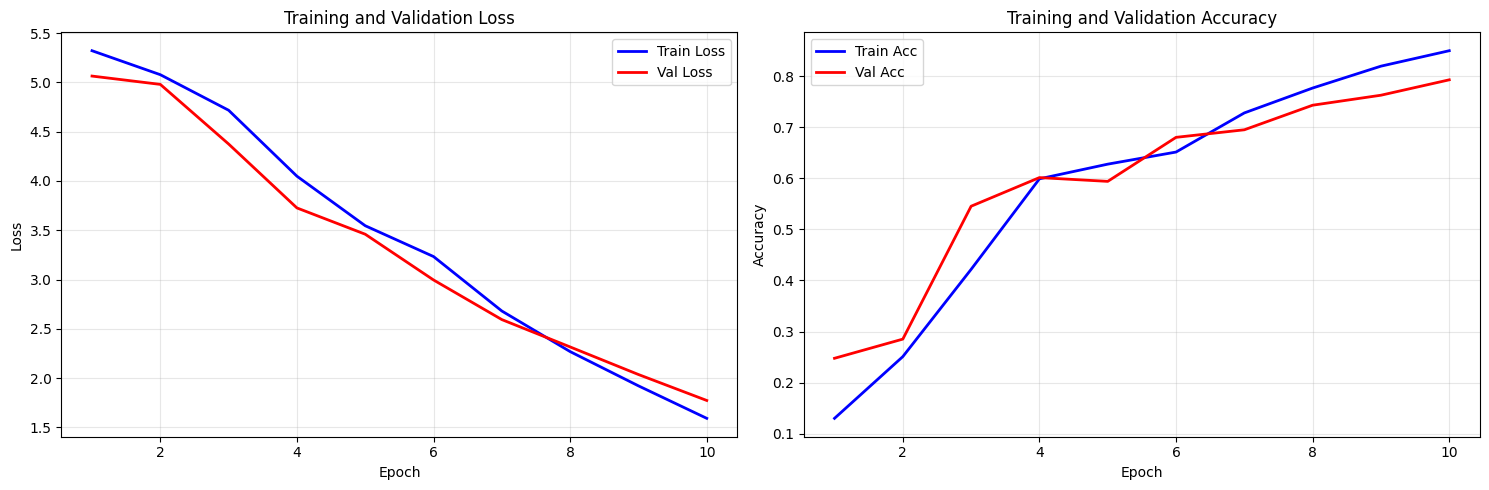

Final Results:
Best Validation Accuracy: 0.7931
Final Train Accuracy: 0.8501
Final Val Accuracy: 0.7931


In [54]:
def plot_training_results(results):
    """Plot training curves"""
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(results['train_losses']) + 1)
    
    # Plot losses
    ax1.plot(epochs, results['train_losses'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, results['val_losses'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracies
    ax2.plot(epochs, results['train_accs'], 'b-', label='Train Acc', linewidth=2)
    ax2.plot(epochs, results['val_accs'], 'r-', label='Val Acc', linewidth=2)
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Final Results:")
    print(f"Best Validation Accuracy: {results['best_acc']:.4f}")
    print(f"Final Train Accuracy: {results['train_accs'][-1]:.4f}")
    print(f"Final Val Accuracy: {results['val_accs'][-1]:.4f}")

# Plot results
plot_training_results(results)

In [55]:
def save_final_model(model, head, classes, config, filepath):
    """Save the final trained model"""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'head_state_dict': head.state_dict(),
        'classes': classes,
        'config': config.__dict__,
        'model_architecture': 'ViT-B-32'
    }
    torch.save(checkpoint, filepath)
    print(f"Model saved to {filepath}")

def load_model(filepath, device):
    """Load a saved model"""
    checkpoint = torch.load(filepath, map_location=device)
    
    # Recreate model
    model, _, _ = open_clip.create_model_and_transforms(
        'ViT-B-32', pretrained='openai'
    )
    head = nn.Linear(model.visual.output_dim, len(checkpoint['classes']))
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    head.load_state_dict(checkpoint['head_state_dict'])
    
    model = model.to(device)
    head = head.to(device)
    
    return model, head, checkpoint['classes']

# Save the final model
save_path = config.RUNS_DIR / "clip" / "final_model.pt"
save_final_model(results['model'], results['head'], results['classes'], config, save_path)

# Example of loading the model back
# loaded_model, loaded_head, loaded_classes = load_model(save_path, device)
print("Model saving functions ready!")

Model saved to /kaggle/working/clip/final_model.pt
Model saving functions ready!


Running performance analysis...
=== PERFORMANCE ANALYSIS ===

 TRAINING SPEED:
  Total training time: 685.3s (11.4 min)
  Average epoch time: 68.5s
  Fastest epoch: 67.9s
  Slowest epoch: 69.1s
  Time per epoch range: 1.2s variance

 MEMORY USAGE:
  Average peak memory: 3796.4 MB (3.71 GB)
  Maximum peak memory: 4859.6 MB (4.75 GB)
  Minimum peak memory: 3530.7 MB (3.45 GB)
  Memory stability: 1328.9 MB variance

 MODEL SIZE:
  Trainable parameters: 151,285,008 (151.29M)
  Memory per parameter: 32.1 bytes/param
  Parameters per MB: 31131 params/MB

 EFFICIENCY METRICS:
  Parameter updates per second: 2207477
  Memory efficiency: 31131 params/MB


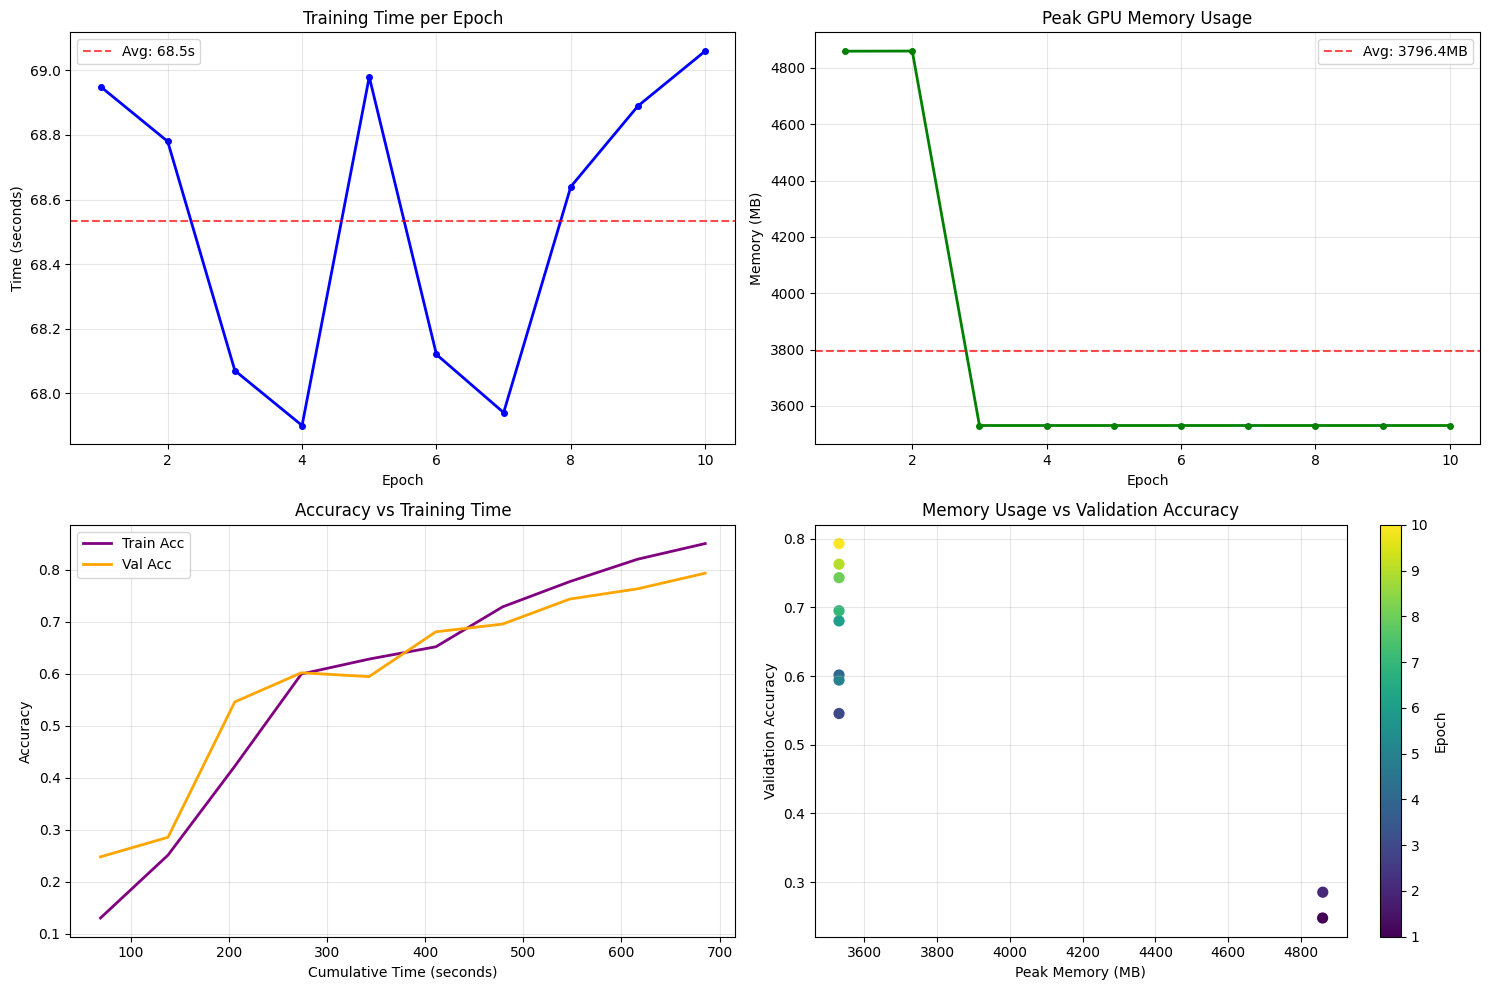


 Performance analysis complete!


In [56]:
def analyze_performance_metrics(csv_path):
    """Analyze and visualize performance metrics from training"""
    import pandas as pd
    
    # Read metrics
    df = pd.read_csv(csv_path)
    
    print("=== PERFORMANCE ANALYSIS ===\n")
    
    # Training speed analysis
    print(" TRAINING SPEED:")
    total_time = df['epoch_time_s'].sum()
    avg_epoch_time = df['epoch_time_s'].mean()
    fastest_epoch = df['epoch_time_s'].min()
    slowest_epoch = df['epoch_time_s'].max()
    
    print(f"  Total training time: {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"  Average epoch time: {avg_epoch_time:.1f}s")
    print(f"  Fastest epoch: {fastest_epoch:.1f}s")
    print(f"  Slowest epoch: {slowest_epoch:.1f}s")
    print(f"  Time per epoch range: {slowest_epoch-fastest_epoch:.1f}s variance")
    
    # Memory usage analysis
    print(f"\n MEMORY USAGE:")
    avg_memory = df['peak_mem_mb'].mean()
    max_memory = df['peak_mem_mb'].max()
    min_memory = df['peak_mem_mb'].min()
    
    print(f"  Average peak memory: {avg_memory:.1f} MB ({avg_memory/1024:.2f} GB)")
    print(f"  Maximum peak memory: {max_memory:.1f} MB ({max_memory/1024:.2f} GB)")
    print(f"  Minimum peak memory: {min_memory:.1f} MB ({min_memory/1024:.2f} GB)")
    print(f"  Memory stability: {max_memory-min_memory:.1f} MB variance")
    
    # Model size analysis
    params = df['trainable_params'].iloc[0]
    print(f"\n MODEL SIZE:")
    print(f"  Trainable parameters: {params:,} ({params/1e6:.2f}M)")
    print(f"  Memory per parameter: {max_memory*1e6/params:.1f} bytes/param")
    print(f"  Parameters per MB: {params/(max_memory):.0f} params/MB")
    
    # Efficiency metrics
    print(f"\n EFFICIENCY METRICS:")
    params_per_sec = params / avg_epoch_time
    mem_efficiency = params / max_memory
    print(f"  Parameter updates per second: {params_per_sec:.0f}")
    print(f"  Memory efficiency: {mem_efficiency:.0f} params/MB")
    
    # Plot performance metrics
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Training time per epoch
    ax1.plot(df['epoch'], df['epoch_time_s'], 'b-o', linewidth=2, markersize=4)
    ax1.set_title('Training Time per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=avg_epoch_time, color='r', linestyle='--', alpha=0.7, label=f'Avg: {avg_epoch_time:.1f}s')
    ax1.legend()
    
    # Peak memory usage
    ax2.plot(df['epoch'], df['peak_mem_mb'], 'g-o', linewidth=2, markersize=4)
    ax2.set_title('Peak GPU Memory Usage')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Memory (MB)')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=avg_memory, color='r', linestyle='--', alpha=0.7, label=f'Avg: {avg_memory:.1f}MB')
    ax2.legend()
    
    # Training efficiency (accuracy gain per time)
    time_cumsum = df['epoch_time_s'].cumsum()
    ax3.plot(time_cumsum, df['train_acc'], 'purple', linewidth=2, label='Train Acc')
    ax3.plot(time_cumsum, df['val_acc'], 'orange', linewidth=2, label='Val Acc')
    ax3.set_title('Accuracy vs Training Time')
    ax3.set_xlabel('Cumulative Time (seconds)')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Memory vs Accuracy
    ax4.scatter(df['peak_mem_mb'], df['val_acc'], c=df['epoch'], cmap='viridis', s=50)
    ax4.set_title('Memory Usage vs Validation Accuracy')
    ax4.set_xlabel('Peak Memory (MB)')
    ax4.set_ylabel('Validation Accuracy')
    ax4.grid(True, alpha=0.3)
    cbar = plt.colorbar(ax4.collections[0], ax=ax4)
    cbar.set_label('Epoch')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'total_time': total_time,
        'avg_epoch_time': avg_epoch_time,
        'peak_memory_mb': max_memory,
        'avg_memory_mb': avg_memory,
        'trainable_params': params,
        'memory_efficiency': mem_efficiency
    }

def benchmark_inference_speed(model, head, test_loader, device, num_samples=100):
    """Benchmark inference speed"""
    model.eval()
    head.eval()
    
    print(" INFERENCE SPEED BENCHMARK:")
    
    times = []
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            if i >= num_samples // images.size(0):  # Test on ~num_samples images
                break
                
            images = images.to(device)
            
            # Warm up GPU
            if i == 0:
                for _ in range(5):
                    _ = get_logits_fn(model, head, images)
            
            # Benchmark
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            start_time = time.time()
            
            logits = get_logits_fn(model, head, images)
            
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            end_time = time.time()
            
            batch_time = end_time - start_time
            times.append(batch_time)
    
    avg_batch_time = np.mean(times)
    std_batch_time = np.std(times)
    images_per_sec = test_loader.batch_size / avg_batch_time
    
    print(f"  Average batch time: {avg_batch_time*1000:.2f} ± {std_batch_time*1000:.2f} ms")
    print(f"  Images per second: {images_per_sec:.1f}")
    print(f"  Time per image: {avg_batch_time*1000/test_loader.batch_size:.2f} ms")
    
    return {
        'avg_batch_time': avg_batch_time,
        'std_batch_time': std_batch_time,
        'images_per_sec': images_per_sec
    }

# Run performance analysis
print("Running performance analysis...")
csv_path = config.RUNS_DIR / "aclip" / "metrics.csv"
perf_metrics = analyze_performance_metrics(csv_path)

# Run inference benchmark
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Note: You'll need to recreate test_loader or pass it from main()
# inference_metrics = benchmark_inference_speed(results['model'], results['head'], test_loader, device)
print("\n Performance analysis complete!")

In [38]:
# This command zips entire output directory into a single file.
# Command '-r' flag means "recursive," so it includes all subfolders.

!zip -r myresults.zip /kaggle/working/clip

  adding: kaggle/working/clip/ (stored 0%)
  adding: kaggle/working/clip/final_model.pt (deflated 35%)
  adding: kaggle/working/clip/logs/ (stored 0%)
  adding: kaggle/working/clip/logs/A-CLIP.log (deflated 88%)


TRAIL